# Things we might need for both midas and adabins

In [ ]:
!pip install timm
!pip install pyngrok==4.1.1
!pip install flask_ngrok
!pip install Pillow
!pip install pyperclip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15979 sha256=db1e0588881b2cfbfa93f87d6b872e495f882c3855e71bc21d2121d1daf2be50
  Stored in directory: /root/.cache/pip/wheels/89/2d/c2/abe6bcfde6bce368c00ecd73310c11edb672c3eda09a090cfa
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing meta

In [ ]:
# import all the goodies we need
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import base64
import torch
import urllib.request
from io import BytesIO
from sklearn.linear_model import LinearRegression

In [ ]:
def output_to_b64(output):
  depths = Image.fromarray(output)
  depths = depths.convert('RGB')
  buffered = BytesIO()
  depths.save(buffered, format='PNG')
  b64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
  return b64

#MiDaS Approach

In [ ]:
# choose the model to load

#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# ... i dunno. transforms or something
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

# set to cuda and go to eval mode
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [ ]:
# convert our image data to a format readable by midas
def get_input_batch(b64):
  image_bytes = base64.b64decode(b64)
  image = Image.open(BytesIO(image_bytes))
  np_img = np.array(image)
  np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
  input_batch = transform(np_img).to(device)
  return input_batch, np_img

def do_prediction_midas(input_batch, np_img):
  with torch.no_grad():
      prediction = midas(input_batch)
      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=np_img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()
  output = prediction.cpu().numpy()
  return output

def output_to_b64(output):
  binary_array = output.tobytes()
  # Send binary over HTTP response
  bites = bytes(binary_array)
  b64 = base64.b64encode(bites).decode('utf-8')
  return b64

# AdaBins Approach

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone 'https://github.com/shariqfarooq123/AdaBins'
%cd AdaBins

Cloning into 'AdaBins'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (80/80), 558.92 KiB | 1.76 MiB/s, done.
/content/AdaBins


In [ ]:
"""
Copy pretrained model into pretrained folder that doesnt yet exist
"""

# import os
# [x for x in os.listdir("../drive/MyDrive") if ".pt" in x]

!mkdir pretrained
!cp ../drive/MyDrive/AdaBins_nyu.pt pretrained/AdaBins_nyu.pt

In [ ]:
# any jpgs i upload will be moved to the test_imgs folder
!mv ../*.jpg test_imgs

mv: cannot stat '../*.jpg': No such file or directory


In [ ]:
"""
predictions using nyu dataset
"""
from infer import InferenceHelper

# use depending on if you have GPU enabled
# infer_helper = InferenceHelper(dataset='nyu')
infer_helper = InferenceHelper(dataset='nyu', device="cpu")

def do_predictions(pil_img):
  bin_centers, predicted_depth = infer_helper.predict_pil(pil_img)
  depths = predicted_depth[0][0]
  return depths

Loading base model ()...

/usr/local/lib/python3.9/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ap-9e82fae8.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ap-9e82fae8.pth


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


In [ ]:
classroom = Image.open("test_imgs/classroom__rgb_00283.jpg")
new_shape = np.array(classroom).shape[:2]

def preprocess(b64):
  image_bytes = base64.b64decode(b64)
  image = Image.open(BytesIO(image_bytes))
  np_img = np.array(image)
  og_shape = np_img.shape[:2]

  # reshape to be of the same size as classroom__rgb_00283
  np_img = cv2.resize(np_img, new_shape)
  pil_img = Image.fromarray(np_img)
  return pil_img, og_shape

def postprocess(output, og_shape):
  depths = cv2.resize(output, og_shape[::-1])
  binary_array = depths.tobytes()
  # Send binary over HTTP response
  bites = bytes(binary_array)
  b64 = base64.b64encode(bites).decode('utf-8')
  return b64, depths

In [ ]:
!ngrok authtoken 2MktNDWGI68ZqbFSpIhkkgnwNoR_3eYQc1R61znkYuyKP4YbF

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import pickle

image = Image.open("../ada test.jpg")
np_img = np.array(image)
og_shape = np_img.shape[:2]
np_img = cv2.resize(np_img, new_shape)
pil_img = Image.fromarray(np_img)
output = do_predictions(pil_img)
out_b64, output = postprocess(output, og_shape)

In [ ]:
with open('ada_depths.pickle', 'rb') as file:
    pickle.dump(output, file)

FileNotFoundError: ignored

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://7584-34-86-93-105.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


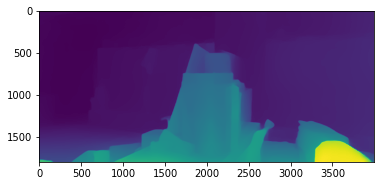

INFO:werkzeug:127.0.0.1 - - [15/Mar/2023 21:41:20] "POST / HTTP/1.1" 200 -


predicted depth is 8.128 meters


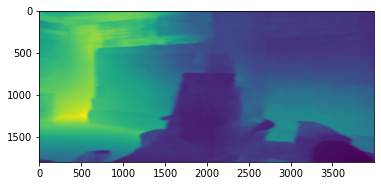

INFO:werkzeug:127.0.0.1 - - [15/Mar/2023 21:42:19] "POST / HTTP/1.1" 200 -


predicted depth is 1.3539856672286987 meters


In [ ]:
reg = -1
def get_reg(d):
  global reg
  if (reg == -1):
    start_distance = 8.128
    x = np.array([d, d * 2])
    x_prime = np.array([start_distance, start_distance / 2])
    reg = LinearRegression().fit(x.reshape(-1, 1), x_prime)
  return reg

turns = ["left", "left"]


from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, request
import os
app = Flask(__name__)
run_with_ngrok(app)
@app.route('/', methods=["POST"])
def inference():
  global turns
  b64 = request.json["b64"]
  model = request.json["model"]

  if (model == "midas"):
    input_batch, np_img = get_input_batch(b64)
    output = do_prediction_midas(input_batch, np_img)
    out_b64 = output_to_b64(output)
  else:
    pil_img, og_shape = preprocess(b64)
    output = do_predictions(pil_img)
    out_b64, output = postprocess(output, og_shape)



  plt.imshow(output)
  plt.show()

  out_h, out_w = output.shape
  d = output[out_h // 2, out_w // 2]

  if (model == "midas"):
    reg = get_reg(d)
    pd = reg.predict(np.array([d]).reshape(-1, 1))[0]
  else:
    pd = d

  command = "advance"
  if (0.25 < pd < 1):
    if (len(turns) > 0):
      command = "turn" + turns[0]
      turns = turns[1:]
    else:
      command = "stop"
  elif (pd < 0.25):
    command = "back up"
  print(f"predicted depth is {pd} meters")

  # return {"out_b64": out_b64, "depth": str(d), "command": command}
  return {"depth": str(pd), "command": command, "out_b64": out_b64}

app.run()